# Working notebook

# Notes on MUSE
* Words in different languages have surprisingly low cosine similarity
  * compare this to antonyms in same language
* Language is a direction

In [2]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\map22\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
drive = 'd'

In [4]:
from numpy.linalg import  norm
def cos_sim(a,b):
    return np.dot(a,b) / (norm(a) * norm(b))

### Merge MUSE embeddings across languages
This takes some finesse. First, use linux cut to get first column as set:

`cut -f1 -d " " wiki.multi.en-es-fr.vec > en_es_fr_tokens.txt `

Then run `filter_muse` to filter one embedding from another.

Then calculate size of new embedding using `cat` and first line of previous embedding (and use `tail -n+2 ...` to cut first, header line from previous embedding.

Then `cat`: 

`cat header.txt wiki.multi.en-es.noheader.vec wiki.multi.fr.filter.vec > wiki.multi.en-es-fr.vec`

In [8]:
def filter_muse(embedding1: str, embedding2: str):
    '''
    '''
    print('Loading first embedding to get tokens')
    df1 = pd.read_csv(embedding1, sep= '\ ', skiprows = 1,
                    header=None, usecols = [0])
    token_set = set(df1[0])
    print('Streaming and filtering second embedding')
    with open(embedding2, 'r', encoding='utf-8') as filter_file:
        with open(embedding2[:-4] + '.filter.vec', 'w', encoding='utf-8') as out_file:
            for line in filter_file:
                if line.split(' ')[0] not in token_set:
                    out_file.write(line)

In [10]:
filter_muse(f'{drive}:/data/token_embeddings/muse/en_es_fr_tokens.txt',
           f'{drive}:/data/token_embeddings/muse/wiki.multi.vi.vec')

Loading first embedding to get tokens


C:\Users\map22\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


Streaming and filtering second embedding


### Load MUSE models

In [3]:
%%time
en_es_muse_model = KeyedVectors.load_word2vec_format(f'{drive}:/data/token_embeddings/muse/wiki.multi.en-es.vec')

Wall time: 1min 22s


#### Load bilingual dictionary

In [160]:
en_es_dict = (pd.read_csv(f'{drive}:/data/token_embeddings/muse/en-es.txt', sep = ' ',
                        header = None, names = ['en', 'es'])
                .query('en != es'))
en_count = en_es_dict['en'].value_counts().reset_index().rename(columns = {'en':'en_count', 'index':'en'})
es_count = en_es_dict['es'].value_counts().reset_index().rename(columns = {'es':'es_count', 'index':'es'})
en_es_dict = en_es_dict.merge(en_count, on = 'en').merge(es_count, on='es')

In [161]:
en_es_dict['es_in_muse'] = en_es_dict['es'].apply(lambda row: row in en_es_muse_model)
en_es_dict['en_in_muse'] = en_es_dict['en'].apply(lambda row: row in en_es_muse_model)
simi_df = en_es_dict.query('en_in_muse and es_in_muse')
simi_df['simi'] = simi_df.apply(lambda row: en_es_muse_model.similarity(row['en'], row['es']), axis = 1 )

C:\Users\map22\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [162]:
simi_df.describe()

,en_count,es_count,simi
count,41353.000000,41353.000000,41353.000000
mean,2.034266,1.778444,0.577634
std,1.195149,0.934420,0.179978
min,1.000000,1.000000,-0.000694
25%,1.000000,1.000000,0.464513
50%,2.000000,2.000000,0.620349
75%,3.000000,2.000000,0.717639
max,6.000000,6.000000,0.953020


In [65]:
en_es_muse_model.most_similar('cerveza')

[('cervecería', 0.7326526641845703),
 ('aguardiente', 0.620478093624115),
 ('campeón', 0.5997775793075562),
 ('queso', 0.5982909202575684),
 ('muestra', 0.5978140830993652),
 ('pacífico', 0.593805193901062),
 ('caña', 0.5887435078620911),
 ('habanos', 0.5859684348106384),
 ('abierta', 0.5799714922904968),
 ('productores', 0.5791232585906982)]

In [66]:
en_es_muse_model.most_similar('egg')

[('eggs', 0.8360580205917358),
 ('huevo', 0.7428090572357178),
 ('yolk', 0.699050784111023),
 ('yolks', 0.686025857925415),
 ('eggshell', 0.630234956741333),
 ('huevas', 0.6180562973022461),
 ('hatching', 0.6175849437713623),
 ('unfertilized', 0.6004554033279419),
 ('eggshells', 0.5988366603851318),
 ('hatchlings', 0.5922733545303345)]

#### Load most common words to see if there is more / less similarity depending on frequency

In [164]:
norvig_df = pd.read_csv('d:/data/token_embeddings/norvig_word_counts.tsv', sep='\t',names = ['word', 'count'])
norvig_df.head(1)

,word,count
0,the,23135851162


In [165]:
simi_df = simi_df.merge(norvig_df, left_on='en', right_on='word', how='left')

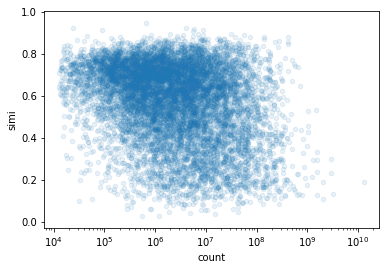

In [166]:
simi_df.sample(10000).plot.scatter('count','simi',  alpha = 0.1)
plt.xscale('log')

In [169]:
common_word_diffs = []
for index, row in simi_df.iterrows():
    common_word_diffs.append(en_es_muse_model[row['en']] - en_es_muse_model[row['es']])
common_word_diffs = np.array(common_word_diffs)
common_direction = common_word_diffs.mean(axis = 0)
simi_df['common_direction_simi'] = [cos_sim(x, common_direction) for x in common_word_diffs]

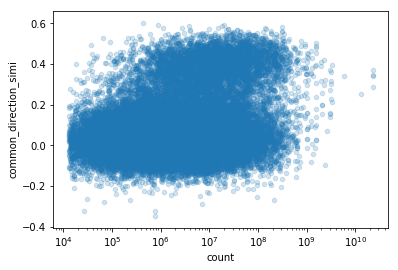

In [170]:
simi_df.plot.scatter('count', 'common_direction_simi', alpha = 0.2)
plt.xscale('log')

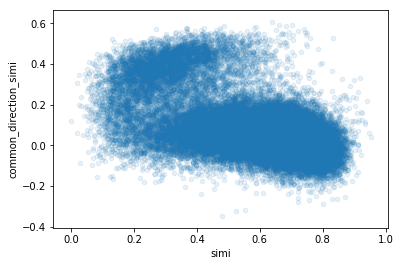

In [176]:
simi_df.plot.scatter('simi', 'common_direction_simi', alpha = 0.1);

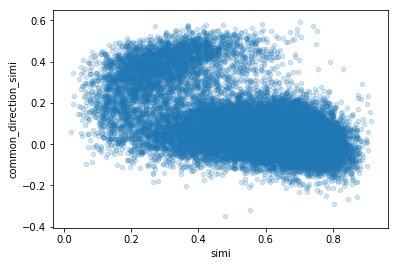

In [174]:
simi_df.query('en_count> 1').plot.scatter('simi', 'common_direction_simi', alpha = 0.2);

#### Appears due to string similarity

In [179]:
simi_df.query('simi > 0.4 and simi < 0.6 and common_direction_simi < 0.2').sample(10)

,en,es,en_count,es_count,es_in_muse,en_in_muse,simi,word,count,common_direction_simi
15582,patronage,patrocinio,2,4,True,True,0.490353,patronage,990921.0,0.038627
16654,flowering,florecimiento,3,3,True,True,0.426108,flowering,2151998.0,-0.026972
27106,pumpkin,calabaza,1,2,True,True,0.558715,pumpkin,3457437.0,0.071745
25724,enrich,enriquecimiento,4,3,True,True,0.577924,enrich,1542232.0,-0.051706
30651,illuminating,esclarecedor,1,2,True,True,0.482093,illuminating,924257.0,0.132645
32452,audited,comprobados,1,1,True,True,0.423341,audited,2100803.0,0.129766
10675,prefer,prefiere,5,2,True,True,0.599708,prefer,16005656.0,-0.070273
28738,computerized,informatizado,1,2,True,True,0.577728,computerized,2455700.0,0.065501
775,targets,objetivos,4,4,True,True,0.588409,targets,14774632.0,0.138417
37310,lusty,lujurioso,1,2,True,True,0.494442,lusty,702157.0,0.075398


In [180]:
simi_df.query('simi > 0.4 and simi < 0.6 and common_direction_simi > 0.3').sample(10)

,en,es,en_count,es_count,es_in_muse,en_in_muse,simi,word,count,common_direction_simi
8301,liverpool,madrid,1,1,True,True,0.495369,liverpool,10118816.0,0.425456
3713,mission,misión,2,1,True,True,0.415513,mission,52716319.0,0.469778
7440,reform,reforma,3,2,True,True,0.457889,reform,22751438.0,0.467435
5367,gardens,jardín,2,2,True,True,0.404717,gardens,18454805.0,0.467310
12682,coin,moneda,2,3,True,True,0.403037,coin,10095328.0,0.467231
1670,combat,combate,3,2,True,True,0.549959,combat,14971773.0,0.526368
5138,reserve,reserva,2,3,True,True,0.529485,reserve,35516087.0,0.430794
13039,plains,llanos,4,1,True,True,0.402713,plains,7584638.0,0.436422
4709,gallery,galería,2,2,True,True,0.544510,gallery,165671626.0,0.509782
37644,sulpicius,sulpicio,1,1,True,True,0.588917,NaN,NaN,0.319610


In [185]:
simi_df['edit_similarity'] = simi_df.apply(lambda row: ratio(row['en'], row['es']), axis=1)

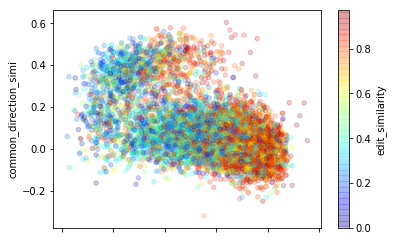

In [197]:
simi_df.sample(10000).plot.scatter('simi', 'common_direction_simi', c = 'edit_similarity',alpha = 0.2, colormap = 'jet');

In [13]:
es_word_count_df = pd.read_csv('d:/data/token_embeddings/cavorite-ngrams-1gram.tsv', sep='\t', 
                              names=['word', 'year', 'a', 'b'])

In [16]:
word_count_agg_df = es_word_count_df.groupby('word').sum().reset_index()
word_count_agg_df[['word', 'b']].to_csv('d:/data/token_embeddings/cavorite_word_counts_es.tsv', sep='\t',
                                       index=False, header=None)